In [13]:
import os
import sys
import time
import numpy as np
from itertools import product
from keras import backend as K
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.externals import joblib
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
random_seed = 42

np.random.seed(random_seed)
tf.set_random_seed(random_seed)

In [3]:
from gesture_comparison_helper import load_gestures
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Utils.data_preparation_helper import load_data_for_classification, prepare_data
from Utils.data_evaluation_helper import parse_classification_report, report_to_latex_table

c:\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
def create_model(n_classes=1, shape=1, num_units=1, loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    # create model
    model = Sequential()
    model.add(LSTM(units=num_units, input_shape=(1, shape)))
    model.add(Dense(n_classes, activation='sigmoid'))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def print_confusion_matrix_colored(confusion_matrix, c_labels, xy_labelsize, c_labelsize, save=None):
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111)
    #ax.set_title('Classification report')
    ax.set_xlabel('prädizierte Klasse', fontsize=xy_labelsize, labelpad=12)
    ax.xaxis.tick_top()
    ax.set_xticks(list(range(len(c_labels))))
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticklabels(c_labels, fontsize=c_labelsize, rotation=90)

    ax.set_ylabel('tatsächliche Klasse', fontsize=xy_labelsize)
    ax.yaxis.set_ticklabels(c_labels, fontsize=c_labelsize)
    ax.set_yticks(list(range(len(c_labels))))

    img = ax.imshow(confusion_matrix, cmap='gray')
    cbar = fig.colorbar(img)
    cbar.ax.tick_params(labelsize=c_labelsize)
    fig.tight_layout()
    if save != None:
        fig.savefig(save)
    plt.show()

## Auswertung der optimalen Parameter - own

In [5]:
#(0.98076923076923073, 4, {'batch_size': 1, 'epochs': 100, 'n_classes': 6, 'num_units': 60, 'optimizer': 'Adam', 'shape': 60})
#(0.92307692307692313, 10, {'batch_size': 1, 'epochs': 100, 'n_classes': 6, 'num_units': 150, 'optimizer': 'Adam', 'shape': 150})
#(0.90384615384615385, 2, {'batch_size': 1, 'epochs': 300, 'n_classes': 6, 'num_units': 44, 'optimizer': 'Adam', 'shape': 44})
#(0.84615384615384615, 10, {'batch_size': 1, 'epochs': 300, 'n_classes': 6, 'num_units': 320, 'optimizer': 'Adam', 'shape': 320})

acc_frames = 4
acc_batch = 1
acc_epochs = 100

gyro_frames = 10
gyro_batch = 1
gyro_epochs = 100

ori_frames = 2
ori_batch = 1
ori_epochs = 300

emg_frames = 10
emg_batch = 1
emg_epochs = 300

In [31]:
start_time = time.time()

train, valid, test = load_data_for_classification('own')

encoder = LabelEncoder()

acc_train_input, acc_train_label = prepare_data(train, acc_frames, 'accelerometer', verbose=False)
acc_valid_input, acc_valid_label = prepare_data(valid, acc_frames, 'accelerometer', verbose=False)
acc_test_input, acc_test_label = prepare_data(test, acc_frames, 'accelerometer', verbose=False)
acc_X_train = acc_train_input.reshape(acc_train_input.shape[0], 1, acc_train_input.shape[1])
acc_y_train = encoder.fit_transform(acc_train_label)
acc_X_valid = acc_valid_input.reshape(acc_valid_input.shape[0], 1, acc_valid_input.shape[1])
acc_y_valid = encoder.fit_transform(acc_valid_label)
acc_X_test = acc_test_input.reshape(acc_test_input.shape[0], 1, acc_test_input.shape[1])
acc_y_test = encoder.fit_transform(acc_test_label)
print('Accelerometer data prepared')

gyro_train_input, gyro_train_label = prepare_data(train, gyro_frames, 'gyro', verbose=False)
gyro_valid_input, gyro_valid_label = prepare_data(valid, gyro_frames, 'gyro', verbose=False)
gyro_test_input, gyro_test_label = prepare_data(test, gyro_frames, 'gyro', verbose=False)
gyro_X_train = gyro_train_input.reshape(gyro_train_input.shape[0], 1, gyro_train_input.shape[1])
gyro_y_train = encoder.fit_transform(gyro_train_label)
gyro_X_valid = gyro_valid_input.reshape(gyro_valid_input.shape[0], 1, gyro_valid_input.shape[1])
gyro_y_valid = encoder.fit_transform(gyro_valid_label)
gyro_X_test = gyro_test_input.reshape(gyro_test_input.shape[0], 1, gyro_test_input.shape[1])
gyro_y_test = encoder.fit_transform(gyro_test_label)
print('Gyroscope data prepared')

ori_train_input, ori_train_label = prepare_data(train, ori_frames, 'orientation', verbose=False)
ori_valid_input, ori_valid_label = prepare_data(valid, ori_frames, 'orientation', verbose=False)
ori_test_input, ori_test_label = prepare_data(test, ori_frames, 'orientation', verbose=False)
ori_X_train = ori_train_input.reshape(ori_train_input.shape[0], 1, ori_train_input.shape[1])
ori_y_train = encoder.fit_transform(ori_train_label)
ori_X_valid = ori_valid_input.reshape(ori_valid_input.shape[0], 1, ori_valid_input.shape[1])
ori_y_valid = encoder.fit_transform(ori_valid_label)
ori_X_test = ori_test_input.reshape(ori_test_input.shape[0], 1, ori_test_input.shape[1])
ori_y_test = encoder.fit_transform(ori_test_label)
print('Orientation data prepared')

emg_train_input, emg_train_label = prepare_data(train, emg_frames, 'emg', verbose=False)
emg_valid_input, emg_valid_label = prepare_data(valid, emg_frames, 'emg', verbose=False)
emg_test_input, emg_test_label = prepare_data(test, emg_frames, 'emg', verbose=False)
emg_X_train = emg_train_input.reshape(emg_train_input.shape[0], 1, emg_train_input.shape[1])
emg_y_train = encoder.fit_transform(emg_train_label)
emg_X_valid = emg_valid_input.reshape(emg_valid_input.shape[0], 1, emg_valid_input.shape[1])
emg_y_valid = encoder.fit_transform(emg_valid_label)
emg_X_test = emg_test_input.reshape(emg_test_input.shape[0], 1, emg_test_input.shape[1])
emg_y_test = encoder.fit_transform(emg_test_label)
print('EMG data prepared')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer data prepared
Gyroscope data prepared
Orientation data prepared
EMG data prepared

Duration: 25.537904500961304


In [7]:
start_time = time.time()

acc_lstm = create_model(n_classes=len(encoder.classes_), num_units=acc_X_train.shape[2], shape=acc_X_train.shape[2])
acc_lstm.fit(np.append(acc_X_train, acc_X_valid, axis=0),np.append(acc_y_train, acc_y_valid), epochs=acc_epochs, batch_size=acc_batch, verbose=0)
print('Accelerometer classifier fitted')

gyro_lstm = create_model(n_classes=len(encoder.classes_), num_units=gyro_X_train.shape[2], shape=gyro_X_train.shape[2])
gyro_lstm.fit(np.append(gyro_X_train, gyro_X_valid, axis=0),np.append(gyro_y_train, gyro_y_valid), epochs=gyro_epochs, batch_size=gyro_batch, verbose=0)
print('Gyroscope classifier fitted')

ori_lstm = create_model(n_classes=len(encoder.classes_), num_units=ori_X_train.shape[2], shape=ori_X_train.shape[2])
ori_lstm.fit(np.append(ori_X_train, ori_X_valid, axis=0),np.append(ori_y_train, ori_y_valid), epochs=ori_epochs, batch_size=ori_batch, verbose=0)
print('Orientation classifier fitted')

emg_lstm = create_model(n_classes=len(encoder.classes_), num_units=emg_X_train.shape[2], shape=emg_X_train.shape[2])
emg_lstm.fit(np.append(emg_X_train, emg_X_valid, axis=0),np.append(emg_y_train, emg_y_valid), epochs=emg_epochs, batch_size=emg_batch, verbose=0)
print('EMG classifier fitted')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer classifier fitted
Gyroscope classifier fitted
Orientation classifier fitted
EMG classifier fitted

Duration: 1906.6218099594116


In [32]:
config ={'acc_frames':acc_frames, 'gyro_frames':gyro_frames, 'ori_frames':ori_frames, 'emg_frames':emg_frames,
         'loss':'sparse_categorical_crossentropy', 'optimizer':'adam', 'metrics':['accuracy']}

save_path = '../Data/models/lstm/'
os.makedirs(save_path, exist_ok=True)

acc_model_json = acc_lstm.to_json()
with open(save_path + 'own_acc_lstm.json', 'w') as json_file:
    json_file.write(acc_model_json)
acc_lstm.save_weights(save_path + 'own_acc_lstm_weights.h5')

gyro_model_json = gyro_lstm.to_json()
with open(save_path + 'own_gyro_lstm.json', 'w') as json_file:
    json_file.write(gyro_model_json)
gyro_lstm.save_weights(save_path + 'own_gyro_lstm_weights.h5')

ori_model_json = ori_lstm.to_json()
with open(save_path + 'own_ori_lstm.json', 'w') as json_file:
    json_file.write(ori_model_json)
ori_lstm.save_weights(save_path + 'own_ori_lstm_weights.h5')

emg_model_json = emg_lstm.to_json()
with open(save_path + 'own_emg_lstm.json', 'w') as json_file:
    json_file.write(emg_model_json)
emg_lstm.save_weights(save_path + 'own_emg_lstm_weights.h5')

joblib.dump(config, save_path + 'own_config.p')
joblib.dump(encoder, save_path + 'own_encoder.p')

config = joblib.load(save_path + 'own_config.p')
encoder = joblib.load(save_path + 'own_encoder.p')

json_file = open(save_path + 'own_acc_lstm.json', 'r')
acc_lstm_json = json_file.read()
json_file.close()
acc_lstm = model_from_json(acc_lstm_json)
acc_lstm.load_weights(save_path + 'own_acc_lstm_weights.h5')
acc_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'own_gyro_lstm.json', 'r')
gyro_lstm_json = json_file.read()
json_file.close()
gyro_lstm = model_from_json(gyro_lstm_json)
gyro_lstm.load_weights(save_path + 'own_gyro_lstm_weights.h5')
gyro_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'own_ori_lstm.json', 'r')
ori_lstm_json = json_file.read()
json_file.close()
ori_lstm = model_from_json(ori_lstm_json)
ori_lstm.load_weights(save_path + 'own_ori_lstm_weights.h5')
ori_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'own_emg_lstm.json', 'r')
emg_lstm_json = json_file.read()
json_file.close()
emg_lstm = model_from_json(emg_lstm_json)
emg_lstm.load_weights(save_path + 'own_emg_lstm_weights.h5')
emg_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

In [15]:
start_time = time.time()

acc_pred_probs = acc_lstm.predict(acc_X_test)
gyro_pred_probs = gyro_lstm.predict(gyro_X_test)
ori_pred_probs = ori_lstm.predict(ori_X_test)
emg_pred_probs = emg_lstm.predict(emg_X_test)

result = []
    
for prediction in range(len(acc_pred_probs)):
    acc_gyro = np.add(acc_pred_probs[prediction], gyro_pred_probs[prediction])
    ori_emg = np.add(ori_pred_probs[prediction], emg_pred_probs[prediction])
    final = np.divide(np.add(acc_gyro, ori_emg), 4)
    result.append(encoder.classes_[np.argmax(final)])
    
print('\nDuration: {}'.format(time.time() - start_time))


Duration: 0.7143669128417969


In [16]:
print(accuracy_score(acc_test_label, result))

0.846153846154


[[ 9  0  0  0  0  0]
 [ 0  6  3  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  3  0  9  0  0]
 [ 0  0  0  0 12  0]
 [ 1  2  1  0  0  8]]


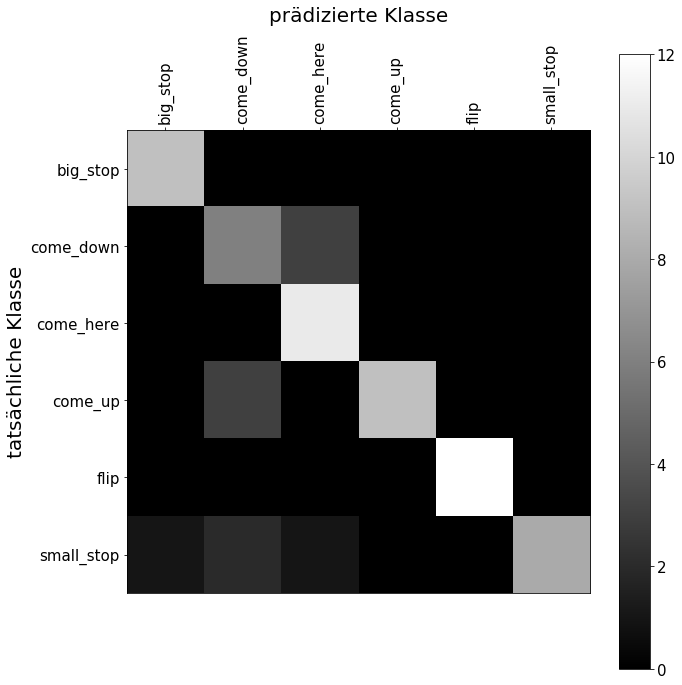

In [17]:
cm = confusion_matrix(acc_test_label, result)
labels = list(encoder.classes_)

print(cm)

print_confusion_matrix_colored(cm, labels, 20, 15)

In [18]:
clf_repo = classification_report(acc_test_label, result)

print(clf_repo)

parsed = parse_classification_report(clf_repo)
output = report_to_latex_table(parsed)
#print(output)

             precision    recall  f1-score   support

   big_stop       0.90      1.00      0.95         9
  come_down       0.55      0.67      0.60         9
  come_here       0.73      1.00      0.85        11
    come_up       1.00      0.75      0.86        12
       flip       1.00      1.00      1.00        12
 small_stop       1.00      0.67      0.80        12

avg / total       0.88      0.85      0.85        65



## Auswertung der optimalen Parameter - paper

In [43]:
#(0.59615384615384615, 5, {'batch_size': 1, 'epochs': 300, 'n_classes': 18, 'num_units': 75, 'optimizer': 'Adam', 'shape': 75})
#(0.52564102564102566, 10, {'batch_size': 1, 'epochs': 300, 'n_classes': 18, 'num_units': 150, 'optimizer': 'Adam', 'shape': 150})
#(0.57692307692307687, 3, {'batch_size': 1, 'epochs': 300, 'n_classes': 18, 'num_units': 66, 'optimizer': 'Adam', 'shape': 66})
#(0.46153846153846156, 10, {'batch_size': 1, 'epochs': 100, 'n_classes': 18, 'num_units': 320, 'optimizer': 'Adam', 'shape': 320})

acc_frames = 5
acc_batch = 1
acc_epochs = 300

gyro_frames = 10
gyro_batch = 1
gyro_epochs = 300

ori_frames = 3
ori_batch = 1
ori_epochs = 300

emg_frames = 10
emg_batch = 1
emg_epochs = 100

In [44]:
start_time = time.time()

train, valid, test = load_data_for_classification('paper')

encoder = LabelEncoder()

acc_train_input, acc_train_label = prepare_data(train, acc_frames, 'accelerometer', verbose=False)
acc_valid_input, acc_valid_label = prepare_data(valid, acc_frames, 'accelerometer', verbose=False)
acc_test_input, acc_test_label = prepare_data(test, acc_frames, 'accelerometer', verbose=False)
acc_X_train = acc_train_input.reshape(acc_train_input.shape[0], 1, acc_train_input.shape[1])
acc_y_train = encoder.fit_transform(acc_train_label)
acc_X_valid = acc_valid_input.reshape(acc_valid_input.shape[0], 1, acc_valid_input.shape[1])
acc_y_valid = encoder.fit_transform(acc_valid_label)
acc_X_test = acc_test_input.reshape(acc_test_input.shape[0], 1, acc_test_input.shape[1])
acc_y_test = encoder.fit_transform(acc_test_label)
print('Accelerometer data prepared')

gyro_train_input, gyro_train_label = prepare_data(train, gyro_frames, 'gyro', verbose=False)
gyro_valid_input, gyro_valid_label = prepare_data(valid, gyro_frames, 'gyro', verbose=False)
gyro_test_input, gyro_test_label = prepare_data(test, gyro_frames, 'gyro', verbose=False)
gyro_X_train = gyro_train_input.reshape(gyro_train_input.shape[0], 1, gyro_train_input.shape[1])
gyro_y_train = encoder.fit_transform(gyro_train_label)
gyro_X_valid = gyro_valid_input.reshape(gyro_valid_input.shape[0], 1, gyro_valid_input.shape[1])
gyro_y_valid = encoder.fit_transform(gyro_valid_label)
gyro_X_test = gyro_test_input.reshape(gyro_test_input.shape[0], 1, gyro_test_input.shape[1])
gyro_y_test = encoder.fit_transform(gyro_test_label)
print('Gyroscope data prepared')

ori_train_input, ori_train_label = prepare_data(train, ori_frames, 'orientation', verbose=False)
ori_valid_input, ori_valid_label = prepare_data(valid, ori_frames, 'orientation', verbose=False)
ori_test_input, ori_test_label = prepare_data(test, ori_frames, 'orientation', verbose=False)
ori_X_train = ori_train_input.reshape(ori_train_input.shape[0], 1, ori_train_input.shape[1])
ori_y_train = encoder.fit_transform(ori_train_label)
ori_X_valid = ori_valid_input.reshape(ori_valid_input.shape[0], 1, ori_valid_input.shape[1])
ori_y_valid = encoder.fit_transform(ori_valid_label)
ori_X_test = ori_test_input.reshape(ori_test_input.shape[0], 1, ori_test_input.shape[1])
ori_y_test = encoder.fit_transform(ori_test_label)
print('Orientation data prepared')

emg_train_input, emg_train_label = prepare_data(train, emg_frames, 'emg', verbose=False)
emg_valid_input, emg_valid_label = prepare_data(valid, emg_frames, 'emg', verbose=False)
emg_test_input, emg_test_label = prepare_data(test, emg_frames, 'emg', verbose=False)
emg_X_train = emg_train_input.reshape(emg_train_input.shape[0], 1, emg_train_input.shape[1])
emg_y_train = encoder.fit_transform(emg_train_label)
emg_X_valid = emg_valid_input.reshape(emg_valid_input.shape[0], 1, emg_valid_input.shape[1])
emg_y_valid = encoder.fit_transform(emg_valid_label)
emg_X_test = emg_test_input.reshape(emg_test_input.shape[0], 1, emg_test_input.shape[1])
emg_y_test = encoder.fit_transform(emg_test_label)
print('EMG data prepared')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer data prepared
Gyroscope data prepared
Orientation data prepared
EMG data prepared

Duration: 79.67390418052673


In [45]:
start_time = time.time()

acc_lstm = create_model(n_classes=len(encoder.classes_), num_units=acc_X_train.shape[2], shape=acc_X_train.shape[2])
acc_lstm.fit(np.append(acc_X_train, acc_X_valid, axis=0),np.append(acc_y_train, acc_y_valid), epochs=acc_epochs, batch_size=acc_batch, verbose=0)
print('Accelerometer classifier fitted')

gyro_lstm = create_model(n_classes=len(encoder.classes_), num_units=gyro_X_train.shape[2], shape=gyro_X_train.shape[2])
gyro_lstm.fit(np.append(gyro_X_train, gyro_X_valid, axis=0),np.append(gyro_y_train, gyro_y_valid), epochs=gyro_epochs, batch_size=gyro_batch, verbose=0)
print('Gyroscope classifier fitted')

ori_lstm = create_model(n_classes=len(encoder.classes_), num_units=ori_X_train.shape[2], shape=ori_X_train.shape[2])
ori_lstm.fit(np.append(ori_X_train, ori_X_valid, axis=0),np.append(ori_y_train, ori_y_valid), epochs=ori_epochs, batch_size=ori_batch, verbose=0)
print('Orientation classifier fitted')

emg_lstm = create_model(n_classes=len(encoder.classes_), num_units=emg_X_train.shape[2], shape=emg_X_train.shape[2])
emg_lstm.fit(np.append(emg_X_train, emg_X_valid, axis=0),np.append(emg_y_train, emg_y_valid), epochs=emg_epochs, batch_size=emg_batch, verbose=0)
print('EMG classifier fitted')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer classifier fitted
Gyroscope classifier fitted
Orientation classifier fitted
EMG classifier fitted

Duration: 10962.828613996506


In [28]:
config ={'acc_frames':acc_frames, 'gyro_frames':gyro_frames, 'ori_frames':ori_frames, 'emg_frames':emg_frames,
         'loss':'sparse_categorical_crossentropy', 'optimizer':'adam', 'metrics':['accuracy']}

save_path = '../Data/models/lstm/'
os.makedirs(save_path, exist_ok=True)

acc_model_json = acc_lstm.to_json()
with open(save_path + 'paper_acc_lstm.json', 'w') as json_file:
    json_file.write(acc_model_json)
acc_lstm.save_weights(save_path + 'paper_acc_lstm_weights.h5')

gyro_model_json = gyro_lstm.to_json()
with open(save_path + 'paper_gyro_lstm.json', 'w') as json_file:
    json_file.write(gyro_model_json)
gyro_lstm.save_weights(save_path + 'paper_gyro_lstm_weights.h5')

ori_model_json = ori_lstm.to_json()
with open(save_path + 'paper_ori_lstm.json', 'w') as json_file:
    json_file.write(ori_model_json)
ori_lstm.save_weights(save_path + 'paper_ori_lstm_weights.h5')

emg_model_json = emg_lstm.to_json()
with open(save_path + 'paper_emg_lstm.json', 'w') as json_file:
    json_file.write(emg_model_json)
emg_lstm.save_weights(save_path + 'paper_emg_lstm_weights.h5')

joblib.dump(config, save_path + 'paper_config.p')
joblib.dump(encoder, save_path + 'paper_encoder.p')

config = joblib.load(save_path + 'paper_config.p')
encoder = joblib.load(save_path + 'paper_encoder.p')

json_file = open(save_path + 'paper_acc_lstm.json', 'r')
acc_lstm_json = json_file.read()
json_file.close()
acc_lstm = model_from_json(acc_lstm_json)
acc_lstm.load_weights(save_path + 'paper_acc_lstm_weights.h5')
acc_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'paper_gyro_lstm.json', 'r')
gyro_lstm_json = json_file.read()
json_file.close()
gyro_lstm = model_from_json(gyro_lstm_json)
gyro_lstm.load_weights(save_path + 'paper_gyro_lstm_weights.h5')
gyro_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'paper_ori_lstm.json', 'r')
ori_lstm_json = json_file.read()
json_file.close()
ori_lstm = model_from_json(ori_lstm_json)
ori_lstm.load_weights(save_path + 'paper_ori_lstm_weights.h5')
ori_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'paper_emg_lstm.json', 'r')
emg_lstm_json = json_file.read()
json_file.close()
emg_lstm = model_from_json(emg_lstm_json)
emg_lstm.load_weights(save_path + 'paper_emg_lstm_weights.h5')
emg_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

In [29]:
start_time = time.time()

acc_pred_probs = acc_lstm.predict(acc_X_test)
gyro_pred_probs = gyro_lstm.predict(gyro_X_test)
ori_pred_probs = ori_lstm.predict(ori_X_test)
emg_pred_probs = emg_lstm.predict(emg_X_test)

result = []
    
for prediction in range(len(acc_pred_probs)):
    acc_gyro = np.add(acc_pred_probs[prediction], gyro_pred_probs[prediction])
    ori_emg = np.add(ori_pred_probs[prediction], emg_pred_probs[prediction])
    final = np.divide(np.add(acc_gyro, ori_emg), 4)
    result.append(encoder.classes_[np.argmax(final)])
    
print('\nDuration: {}'.format(time.time() - start_time))


Duration: 1.4360237121582031


In [30]:
print(accuracy_score(acc_test_label, result))

0.288659793814


[[3 0 0 3 1 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 3 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0]
 [0 0 1 0 0 0 0 0 3 0 0 1 0 2 2 0 0 0]
 [0 1 0 3 0 0 0 0 0 0 0 1 2 1 0 0 0 1]
 [0 2 0 0 6 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 2 0 0 0 4 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 2 0 0 4 0 0 1 0 0 2 0 0 0 0 0]
 [0 1 0 0 0 0 0 2 0 0 0 0 1 6 0 0 0 1]
 [0 0 0 0 0 0 0 0 6 0 0 2 1 0 3 0 0 0]
 [0 0 0 1 0 0 3 0 1 0 0 1 2 0 0 3 0 1]
 [0 0 0 0 2 0 0 3 0 0 5 0 0 0 0 0 2 0]
 [0 0 0 2 0 1 0 0 5 0 0 1 0 0 2 0 0 1]
 [2 0 0 0 0 0 1 0 0 0 0 1 0 0 2 6 0 0]
 [0 0 0 0 0 0 0 6 0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 1 0 0 2 0 0 2 0 0 7 0 0 0]
 [1 0 0 1 1 0 2 0 1 0 0 2 1 0 1 2 0 0]
 [0 2 0 0 2 0 0 1 0 0 5 0 0 0 0 0 2 0]
 [0 2 0 0 0 2 0 0 1 0 0 5 0 0 1 0 0 1]]


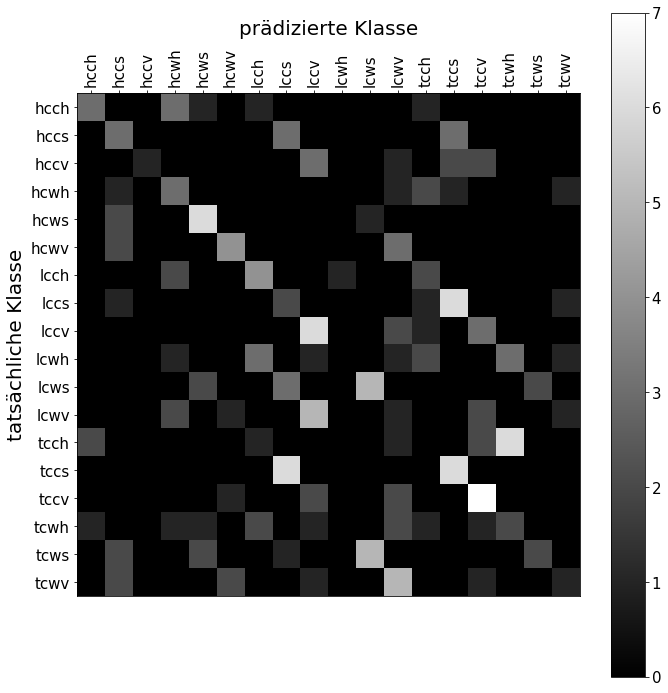

In [26]:
cm = confusion_matrix(acc_test_label, result)
labels = list(encoder.classes_)

print(cm)

print_confusion_matrix_colored(cm, labels, 20, 15)

In [27]:
clf_repo = classification_report(acc_test_label, result)

print(clf_repo)

parsed = parse_classification_report(clf_repo)
output = report_to_latex_table(parsed)
#print(output)

             precision    recall  f1-score   support

       hcch       0.50      0.33      0.40         9
       hccs       0.23      0.33      0.27         9
       hccv       1.00      0.11      0.20         9
       hcwh       0.25      0.33      0.29         9
       hcws       0.50      0.67      0.57         9
       hcwv       0.50      0.44      0.47         9
       lcch       0.36      0.44      0.40         9
       lccs       0.13      0.18      0.15        11
       lccv       0.32      0.50      0.39        12
       lcwh       0.00      0.00      0.00        12
       lcws       0.45      0.42      0.43        12
       lcwv       0.05      0.08      0.06        12
       tcch       0.00      0.00      0.00        12
       tccs       0.33      0.50      0.40        12
       tccv       0.39      0.58      0.47        12
       tcwh       0.18      0.17      0.17        12
       tcws       0.50      0.17      0.25        12
       tcwv       0.20      0.08      0.12   

## Auswertung der optimalen Parameter - all

In [33]:
#(0.64251207729468596, 4, {'batch_size': 1, 'epochs': 300, 'n_classes': 24, 'num_units': 60, 'optimizer': 'Adam', 'shape': 60})
#(0.53623188405797106, 12, {'batch_size': 10, 'epochs': 300, 'n_classes': 24, 'num_units': 180, 'optimizer': 'Adam', 'shape': 180})
#(0.61352657004830913, 3, {'batch_size': 1, 'epochs': 300, 'n_classes': 24, 'num_units': 66, 'optimizer': 'Adam', 'shape': 66})
### emg ###
#(0.59134615384615385, 8, {'shape': 256, 'batch_size': 1, 'n_classes': 24, 'optimizer': 'Adam', 'num_units': 256, 'epochs': 300})

acc_frames = 4
acc_batch = 1
acc_epochs = 300

gyro_frames = 12
gyro_batch = 10
gyro_epochs = 300

ori_frames = 3
ori_batch = 1
ori_epochs = 300

emg_frames = 8
emg_batch = 1
emg_epochs = 300

In [34]:
start_time = time.time()

train, valid, test = load_data_for_classification('all')

encoder = LabelEncoder()

acc_train_input, acc_train_label = prepare_data(train, acc_frames, 'accelerometer', verbose=False)
acc_valid_input, acc_valid_label = prepare_data(valid, acc_frames, 'accelerometer', verbose=False)
acc_test_input, acc_test_label = prepare_data(test, acc_frames, 'accelerometer', verbose=False)
acc_X_train = acc_train_input.reshape(acc_train_input.shape[0], 1, acc_train_input.shape[1])
acc_y_train = encoder.fit_transform(acc_train_label)
acc_X_valid = acc_valid_input.reshape(acc_valid_input.shape[0], 1, acc_valid_input.shape[1])
acc_y_valid = encoder.fit_transform(acc_valid_label)
acc_X_test = acc_test_input.reshape(acc_test_input.shape[0], 1, acc_test_input.shape[1])
acc_y_test = encoder.fit_transform(acc_test_label)
print('Accelerometer data prepared')

gyro_train_input, gyro_train_label = prepare_data(train, gyro_frames, 'gyro', verbose=False)
gyro_valid_input, gyro_valid_label = prepare_data(valid, gyro_frames, 'gyro', verbose=False)
gyro_test_input, gyro_test_label = prepare_data(test, gyro_frames, 'gyro', verbose=False)
gyro_X_train = gyro_train_input.reshape(gyro_train_input.shape[0], 1, gyro_train_input.shape[1])
gyro_y_train = encoder.fit_transform(gyro_train_label)
gyro_X_valid = gyro_valid_input.reshape(gyro_valid_input.shape[0], 1, gyro_valid_input.shape[1])
gyro_y_valid = encoder.fit_transform(gyro_valid_label)
gyro_X_test = gyro_test_input.reshape(gyro_test_input.shape[0], 1, gyro_test_input.shape[1])
gyro_y_test = encoder.fit_transform(gyro_test_label)
print('Gyroscope data prepared')

ori_train_input, ori_train_label = prepare_data(train, ori_frames, 'orientation', verbose=False)
ori_valid_input, ori_valid_label = prepare_data(valid, ori_frames, 'orientation', verbose=False)
ori_test_input, ori_test_label = prepare_data(test, ori_frames, 'orientation', verbose=False)
ori_X_train = ori_train_input.reshape(ori_train_input.shape[0], 1, ori_train_input.shape[1])
ori_y_train = encoder.fit_transform(ori_train_label)
ori_X_valid = ori_valid_input.reshape(ori_valid_input.shape[0], 1, ori_valid_input.shape[1])
ori_y_valid = encoder.fit_transform(ori_valid_label)
ori_X_test = ori_test_input.reshape(ori_test_input.shape[0], 1, ori_test_input.shape[1])
ori_y_test = encoder.fit_transform(ori_test_label)
print('Orientation data prepared')

emg_train_input, emg_train_label = prepare_data(train, emg_frames, 'emg', verbose=False)
emg_valid_input, emg_valid_label = prepare_data(valid, emg_frames, 'emg', verbose=False)
emg_test_input, emg_test_label = prepare_data(test, emg_frames, 'emg', verbose=False)
emg_X_train = emg_train_input.reshape(emg_train_input.shape[0], 1, emg_train_input.shape[1])
emg_y_train = encoder.fit_transform(emg_train_label)
emg_X_valid = emg_valid_input.reshape(emg_valid_input.shape[0], 1, emg_valid_input.shape[1])
emg_y_valid = encoder.fit_transform(emg_valid_label)
emg_X_test = emg_test_input.reshape(emg_test_input.shape[0], 1, emg_test_input.shape[1])
emg_y_test = encoder.fit_transform(emg_test_label)
print('EMG data prepared')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer data prepared
Gyroscope data prepared
Orientation data prepared
EMG data prepared

Duration: 82.41763257980347


In [35]:
start_time = time.time()

acc_lstm = create_model(n_classes=len(encoder.classes_), num_units=acc_X_train.shape[2], shape=acc_X_train.shape[2])
acc_lstm.fit(np.append(acc_X_train, acc_X_valid, axis=0),np.append(acc_y_train, acc_y_valid), epochs=acc_epochs, batch_size=acc_batch, verbose=0)
print('Accelerometer classifier fitted')

gyro_lstm = create_model(n_classes=len(encoder.classes_), num_units=gyro_X_train.shape[2], shape=gyro_X_train.shape[2])
gyro_lstm.fit(np.append(gyro_X_train, gyro_X_valid, axis=0),np.append(gyro_y_train, gyro_y_valid), epochs=gyro_epochs, batch_size=gyro_batch, verbose=0)
print('Gyroscope classifier fitted')

ori_lstm = create_model(n_classes=len(encoder.classes_), num_units=ori_X_train.shape[2], shape=ori_X_train.shape[2])
ori_lstm.fit(np.append(ori_X_train, ori_X_valid, axis=0),np.append(ori_y_train, ori_y_valid), epochs=ori_epochs, batch_size=ori_batch, verbose=0)
print('Orientation classifier fitted')

emg_lstm = create_model(n_classes=len(encoder.classes_), num_units=emg_X_train.shape[2], shape=emg_X_train.shape[2])
emg_lstm.fit(np.append(emg_X_train, emg_X_valid, axis=0),np.append(emg_y_train, emg_y_valid), epochs=emg_epochs, batch_size=emg_batch, verbose=0)
print('EMG classifier fitted')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer classifier fitted
Gyroscope classifier fitted
Orientation classifier fitted
EMG classifier fitted

Duration: 5552.620501995087


In [38]:
config ={'acc_frames':acc_frames, 'gyro_frames':gyro_frames, 'ori_frames':ori_frames, 'emg_frames':emg_frames,
         'loss':'sparse_categorical_crossentropy', 'optimizer':'adam', 'metrics':['accuracy']}

save_path = '../Data/models/lstm/'
os.makedirs(save_path, exist_ok=True)

acc_model_json = acc_lstm.to_json()
with open(save_path + 'all_acc_lstm.json', 'w') as json_file:
    json_file.write(acc_model_json)
acc_lstm.save_weights(save_path + 'all_acc_lstm_weights.h5')

gyro_model_json = gyro_lstm.to_json()
with open(save_path + 'all_gyro_lstm.json', 'w') as json_file:
    json_file.write(gyro_model_json)
gyro_lstm.save_weights(save_path + 'all_gyro_lstm_weights.h5')

ori_model_json = ori_lstm.to_json()
with open(save_path + 'all_ori_lstm.json', 'w') as json_file:
    json_file.write(ori_model_json)
ori_lstm.save_weights(save_path + 'all_ori_lstm_weights.h5')

emg_model_json = emg_lstm.to_json()
with open(save_path + 'all_emg_lstm.json', 'w') as json_file:
    json_file.write(emg_model_json)
emg_lstm.save_weights(save_path + 'all_emg_lstm_weights.h5')

joblib.dump(config, save_path + 'all_config.p')
joblib.dump(encoder, save_path + 'all_encoder.p')

config = joblib.load(save_path + 'all_config.p')
encoder = joblib.load(save_path + 'all_encoder.p')

json_file = open(save_path + 'all_acc_lstm.json', 'r')
acc_lstm_json = json_file.read()
json_file.close()
acc_lstm = model_from_json(acc_lstm_json)
acc_lstm.load_weights(save_path + 'all_acc_lstm_weights.h5')
acc_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'all_gyro_lstm.json', 'r')
gyro_lstm_json = json_file.read()
json_file.close()
gyro_lstm = model_from_json(gyro_lstm_json)
gyro_lstm.load_weights(save_path + 'all_gyro_lstm_weights.h5')
gyro_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'all_ori_lstm.json', 'r')
ori_lstm_json = json_file.read()
json_file.close()
ori_lstm = model_from_json(ori_lstm_json)
ori_lstm.load_weights(save_path + 'all_ori_lstm_weights.h5')
ori_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

json_file = open(save_path + 'all_emg_lstm.json', 'r')
emg_lstm_json = json_file.read()
json_file.close()
emg_lstm = model_from_json(emg_lstm_json)
emg_lstm.load_weights(save_path + 'all_emg_lstm_weights.h5')
emg_lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metrics'])

In [39]:
start_time = time.time()

acc_pred_probs = acc_lstm.predict(acc_X_test)
gyro_pred_probs = gyro_lstm.predict(gyro_X_test)
ori_pred_probs = ori_lstm.predict(ori_X_test)
emg_pred_probs = emg_lstm.predict(emg_X_test)

result = []
    
for prediction in range(len(acc_pred_probs)):
    acc_gyro = np.add(acc_pred_probs[prediction], gyro_pred_probs[prediction])
    ori_emg = np.add(ori_pred_probs[prediction], emg_pred_probs[prediction])
    final = np.divide(np.add(acc_gyro, ori_emg), 4)
    result.append(encoder.classes_[np.argmax(final)])
    
print('\nDuration: {}'.format(time.time() - start_time))


Duration: 2.0842297077178955


In [40]:
print(accuracy_score(acc_test_label, result))

0.393822393822


[[5 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 5 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 1 0 6 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 3]
 [0 0 0 0 0 0 3 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 4 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 3 0 2 0 0]
 [0 0 0 0 0 0 2 0 0 6 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 2 0 0 6 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 9 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 2 0 0 0 0 0 0 1 0 3 0 0 0 1 0 1 2 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 3 1 0 1 0 2 0 3 0 0 1]
 [0 0 0 0 0 3 0 0 0 0 0 2 0 1 0 0 0 0 2 1 0 2 0 1]
 [0 1 0 0 0 0 2 0 0 2 0 0 1 0 0 2 0 0 0 0 0 0 3 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 5 0 0 2 0 0 2 0 0 0 2]
 [1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 5 1 0]
 [0 1 0 0 0 0 1 1 0 0 0 0 1 0 0

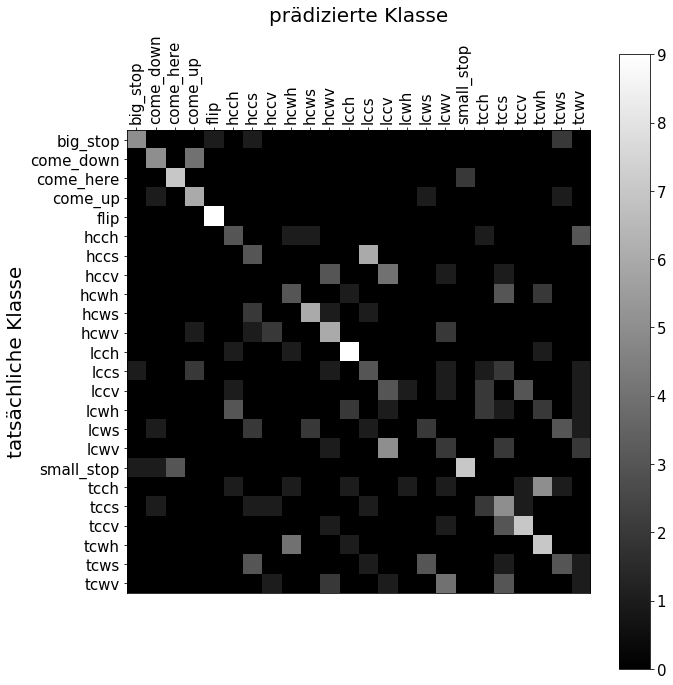

In [41]:
cm = confusion_matrix(acc_test_label, result)
labels = list(encoder.classes_)

print(cm)

print_confusion_matrix_colored(cm, labels, 20, 15)

In [42]:
clf_repo = classification_report(acc_test_label, result)

print(clf_repo)

parsed = parse_classification_report(clf_repo)
output = report_to_latex_table(parsed)
#print(output)

             precision    recall  f1-score   support

   big_stop       0.71      0.56      0.63         9
  come_down       0.56      0.56      0.56         9
  come_here       0.70      0.78      0.74         9
    come_up       0.46      0.67      0.55         9
       flip       0.90      1.00      0.95         9
       hcch       0.33      0.33      0.33         9
       hccs       0.23      0.33      0.27         9
       hccv       0.00      0.00      0.00         9
       hcwh       0.30      0.33      0.32         9
       hcws       0.67      0.60      0.63        10
       hcwv       0.40      0.50      0.44        12
       lcch       0.64      0.75      0.69        12
       lccs       0.23      0.25      0.24        12
       lccv       0.21      0.25      0.23        12
       lcwh       0.00      0.00      0.00        12
       lcws       0.33      0.17      0.22        12
       lcwv       0.15      0.17      0.16        12
 small_stop       0.78      0.58      0.67   